**1. Importing Required Libraries and Setting Up Environment**

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import zipfile
import hashlib

# For inline plotting in Colab/Jupyter Notebook
%matplotlib inline

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


**2. Setting Dataset URLs, Filenames, and Extraction Paths**

In [19]:
# Dataset URLs
images_url = "https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz"
annots_url = "https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip"

# Local filenames
images_tar = "mpii_human_pose_v1.tar.gz"
annots_zip = "mpii_human_pose_v1_u12_2.zip"

# Directories for extraction
images_dir = "./MPII/images/"
annots_dir = "./MPII/annotations/"

# Create directories if they do not exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(annots_dir, exist_ok=True)


**3. Downloading the MPII Dataset (If Not Already Present)**

In [20]:
# Download images archive if not present
if not os.path.exists(images_tar):
    print("Downloading images archive...")
    !wget {images_url} -O {images_tar}
else:
    print("Images archive already exists.")

# Download annotations archive if not present
if not os.path.exists(annots_zip):
    print("Downloading annotations archive...")
    !wget {annots_url} -O {annots_zip}
else:
    print("Annotations archive already exists.")


Images archive already exists.
Annotations archive already exists.


**4. Verifying Dataset Integrity Using MD5 Checksums**


In [21]:
def compute_md5(fname, chunk_size=8192):
    md5 = hashlib.md5()
    with open(fname, 'rb') as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            md5.update(chunk)
    return md5.hexdigest()

print("MD5 for images archive:", compute_md5(images_tar))
print("MD5 for annotations archive:", compute_md5(annots_zip))


MD5 for images archive: cc9a042b57286396d6e5701b75b3748e
MD5 for annotations archive: eb06d7b6f9616742896e0b0fef8ee701


**5. Extracting Images and Annotations from the Archives**


In [22]:
# Extract images archive
try:
    if not os.listdir(images_dir):
        print("Extracting images archive...")
        with tarfile.open(images_tar, "r:*") as tar:
            tar.extractall(path=images_dir)
        print("Images extracted successfully.")
    else:
        print("Images already extracted.")
except Exception as e:
    print("Error during images extraction:", e)

# Extract annotations archive
try:
    if not os.listdir(annots_dir):
        print("Extracting annotations archive...")
        with zipfile.ZipFile(annots_zip, "r") as zip_ref:
            zip_ref.extractall(annots_dir)
        print("Annotations extracted successfully.")
    else:
        print("Annotations already extracted.")
except Exception as e:
    print("Error during annotations extraction:", e)


Images already extracted.
Annotations already extracted.


**6. Loading and Displaying a Sample Image from the MPII Dataset**

Number of images found: 18618


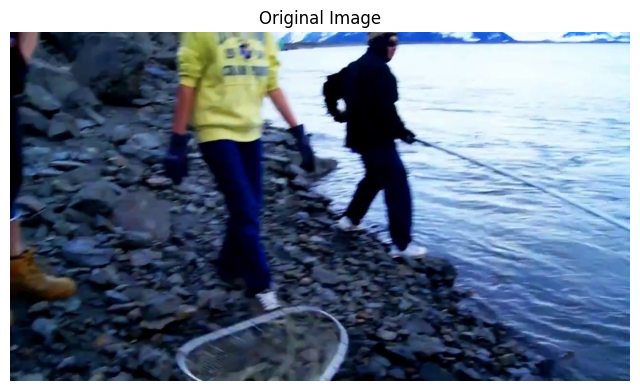

In [23]:
# Recursively list image files (jpg, jpeg, png) in the images directory
image_files = []
for root, dirs, files in os.walk(images_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))

print("Number of images found:", len(image_files))

# Choose one sample image (adjust index as needed)
if image_files:
    sample_image_path = image_files[0]
    img = cv2.imread(sample_image_path)
    if img is None:
        raise Exception("Error loading image: " + sample_image_path)
    # Convert from BGR to RGB for proper visualization
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
else:
    raise Exception("No image files found!")


**7. Image Preprocessing: Grayscale Conversion, Blurring, and Edge Detection**


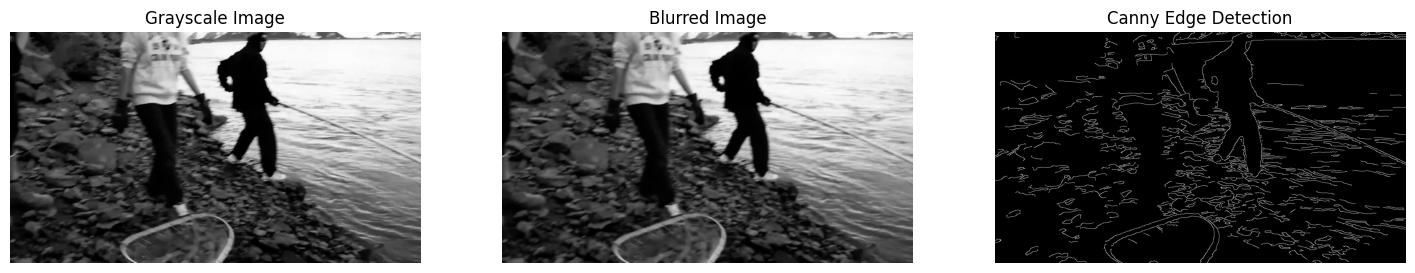

In [24]:
# Convert to grayscale
gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Apply Gaussian Blur to reduce noise
blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

# Apply Canny edge detection (adjust thresholds as needed)
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blurred_img, low_threshold, high_threshold)

# Display Grayscale, Blurred, and Edge Detection Images side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(gray_img, cmap="gray")
axes[0].set_title("Grayscale Image")
axes[0].axis("off")

axes[1].imshow(blurred_img, cmap="gray")
axes[1].set_title("Blurred Image")
axes[1].axis("off")

axes[2].imshow(edges, cmap="gray")
axes[2].set_title("Canny Edge Detection")
axes[2].axis("off")

plt.show()


**8. Extracting and Visualizing Contours from the Edge Image**

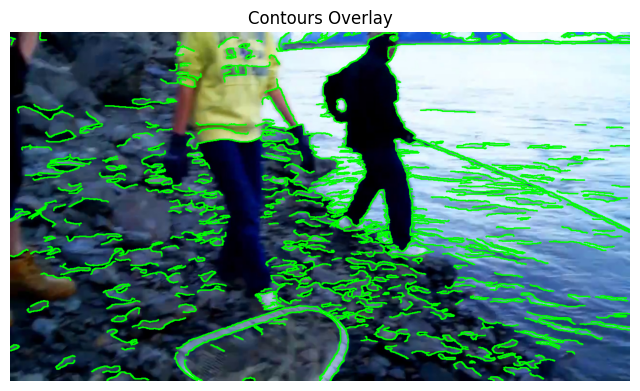

Number of contours found: 591


In [25]:
# Extract contours from the Canny edge image
contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw contours on
contour_overlay = img_rgb.copy()
cv2.drawContours(contour_overlay, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(contour_overlay)
plt.title("Contours Overlay")
plt.axis("off")
plt.show()

print("Number of contours found:", len(contours))


**9. Detecting Potential Joint Locations Using Harris Corner Detection**


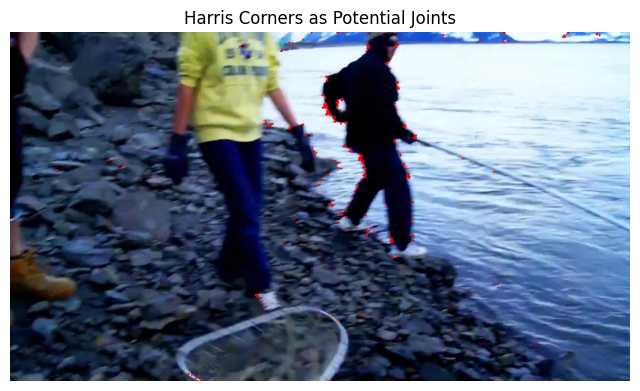

In [26]:
# Convert grayscale image to float32 for Harris corner detection
gray_float = np.float32(gray_img)
block_size = 2
ksize = 3
k = 0.04

harris_response = cv2.cornerHarris(gray_float, block_size, ksize, k)
harris_response = cv2.dilate(harris_response, None)  # Dilate for better visibility
corner_threshold = 0.01 * harris_response.max()

joint_img = img_rgb.copy()
# Mark detected corners in red where Harris response exceeds threshold
joint_img[harris_response > corner_threshold] = [255, 0, 0]

plt.figure(figsize=(8, 6))
plt.imshow(joint_img)
plt.title("Harris Corners as Potential Joints")
plt.axis("off")
plt.show()


**10. Clustering Harris Corners to Estimate Joint Candidates**


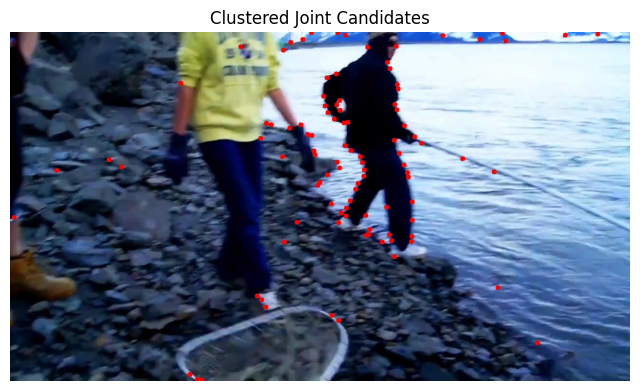

Number of clustered joints: 101


In [27]:
# Get coordinates of points where the Harris response exceeds the threshold
# np.argwhere returns coordinates in (row, col) format, corresponding to (y, x)
corner_points = np.argwhere(harris_response > corner_threshold)

def cluster_points(points, distance_threshold=15):
    """
    Cluster points that are within a specified distance threshold.
    Returns an array of cluster centroids.
    """
    points = list(points)
    clusters = []
    while points:
        base_point = points.pop(0)
        cluster = [base_point]
        indices_to_remove = []
        for i, pt in enumerate(points):
            if np.linalg.norm(base_point - pt) < distance_threshold:
                cluster.append(pt)
                indices_to_remove.append(i)
        for i in sorted(indices_to_remove, reverse=True):
            points.pop(i)
        clusters.append(np.mean(cluster, axis=0).astype(int))
    return np.array(clusters)

clustered_joints = cluster_points(corner_points, distance_threshold=15)

# Overlay the clustered joint candidates on the original image
cluster_overlay = img_rgb.copy()
for (y, x) in clustered_joints:
    cv2.circle(cluster_overlay, (x, y), 5, (255, 0, 0), -1)

plt.figure(figsize=(8, 6))
plt.imshow(cluster_overlay)
plt.title("Clustered Joint Candidates")
plt.axis("off")
plt.show()

print("Number of clustered joints:", len(clustered_joints))


**11. Creating a Basic Skeleton by Naively Connecting Joints**


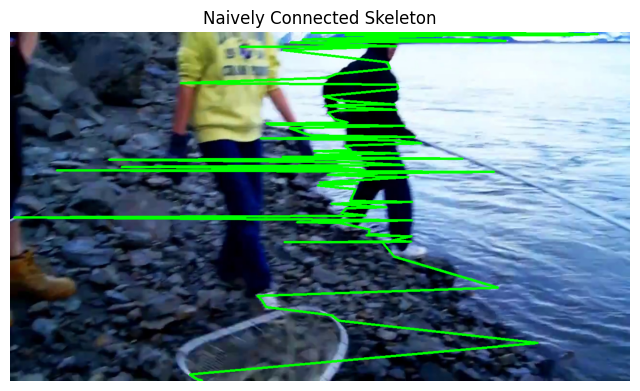

In [28]:
# Sort clustered joints by their y-coordinate (top-to-bottom)
sorted_joints = clustered_joints[clustered_joints[:, 0].argsort()]

skeleton_img = img_rgb.copy()
# Draw lines between consecutive joints as a very basic heuristic
for i in range(len(sorted_joints) - 1):
    y1, x1 = sorted_joints[i]
    y2, x2 = sorted_joints[i+1]
    cv2.line(skeleton_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

plt.figure(figsize=(8, 6))
plt.imshow(skeleton_img)
plt.title("Naively Connected Skeleton")
plt.axis("off")
plt.show()


**12. Heuristic Labeling of Key Joints and Drawing a Detailed Skeleton**


Joints used for labeling: {'Head': array([  1, 622]), 'Shoulder_L': array([  1, 676]), 'Shoulder_R': array([   2, 1016]), 'Hip_L': array([   4, 1213]), 'Hip_R': array([   6, 1146]), 'Knee': array([  6, 692])}


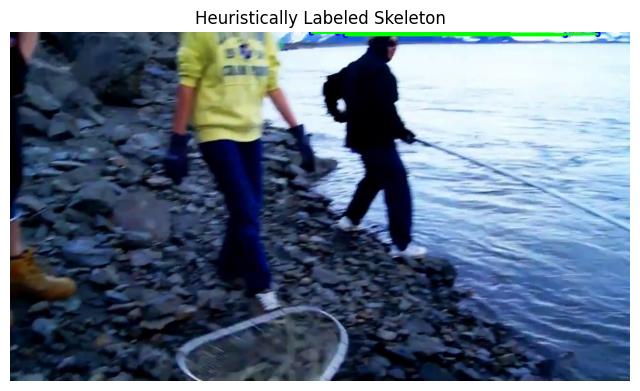

In [51]:
if len(sorted_joints) >= 6:
    # Heuristically assign joints
    head = sorted_joints[0]
    shoulder_left = sorted_joints[1]
    shoulder_right = sorted_joints[2]
    hip_left = sorted_joints[3]
    hip_right = sorted_joints[4]
    knee = sorted_joints[5]

    skeleton_detailed = img_rgb.copy()

    # Dictionary of joints with labels
    joints = {
        "Head": head,
        "Shoulder_L": shoulder_left,
        "Shoulder_R": shoulder_right,
        "Hip_L": hip_left,
        "Hip_R": hip_right,
        "Knee": knee
    }

    print("Joints used for labeling:", joints)

    # Draw circles and labels
    for label, (y, x) in joints.items():
        cv2.circle(skeleton_detailed, (x, y), 6, (0, 0, 255), -1)
        cv2.putText(skeleton_detailed, label, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.4, (255, 255, 0), 1)

    # Draw lines between joints
    cv2.line(skeleton_detailed, (head[1], head[0]), (shoulder_left[1], shoulder_left[0]), (0,255,0), 3)
    cv2.line(skeleton_detailed, (head[1], head[0]), (shoulder_right[1], shoulder_right[0]), (0,255,0), 3)
    cv2.line(skeleton_detailed, (shoulder_left[1], shoulder_left[0]), (hip_left[1], hip_left[0]), (0,255,0), 3)
    cv2.line(skeleton_detailed, (shoulder_right[1], shoulder_right[0]), (hip_right[1], hip_right[0]), (0,255,0), 3)
    cv2.line(skeleton_detailed, (hip_left[1], hip_left[0]), (knee[1], knee[0]), (0,255,0), 3)
    cv2.line(skeleton_detailed, (hip_right[1], hip_right[0]), (knee[1], knee[0]), (0,255,0), 3)

    # Show the image
    plt.figure(figsize=(8, 6))
    plt.imshow(skeleton_detailed)
    plt.title("Heuristically Labeled Skeleton")
    plt.axis("off")
    plt.show()

    # Save the result
    cv2.imwrite("skeleton_output.png", cv2.cvtColor(skeleton_detailed, cv2.COLOR_RGB2BGR))

else:
    print("Not enough clustered joints to apply detailed heuristic labeling.")


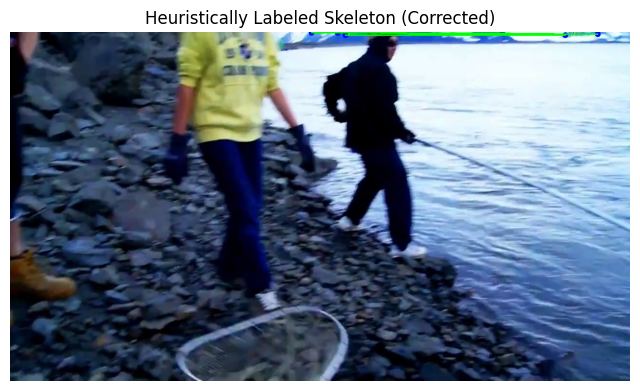

In [61]:
# Replace with your actual original dimensions (check the image before resizing)
original_width = 1280
original_height = 720

# Get current image size
height, width = img_rgb.shape[:2]

# Compute scale factors from original to current
scale_x = width / original_width
scale_y = height / original_height

# Original joint points (from full-sized image)
original_joints = [
    (1, 622),     # Head
    (1, 676),     # Shoulder Left
    (2, 1016),    # Shoulder Right
    (4, 1213),    # Hip Left
    (6, 1146),    # Hip Right
    (6, 692),     # Knee
]

# Apply scaling
scaled_joints = [(int(y * scale_y), int(x * scale_x)) for (y, x) in original_joints]

# Unpack joints after scaling
head, shoulder_left, shoulder_right, hip_left, hip_right, knee = scaled_joints

# Draw
skeleton_img = img_rgb.copy()
joints = {
    "Head": head,
    "Shoulder_L": shoulder_left,
    "Shoulder_R": shoulder_right,
    "Hip_L": hip_left,
    "Hip_R": hip_right,
    "Knee": knee
}

for label, (y, x) in joints.items():
    cv2.circle(skeleton_img, (x, y), 6, (0, 0, 255), -1)
    cv2.putText(skeleton_img, label, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.4, (255, 255, 0), 1)

# Lines
cv2.line(skeleton_img, (head[1], head[0]), (shoulder_left[1], shoulder_left[0]), (0,255,0), 2)
cv2.line(skeleton_img, (head[1], head[0]), (shoulder_right[1], shoulder_right[0]), (0,255,0), 2)
cv2.line(skeleton_img, (shoulder_left[1], shoulder_left[0]), (hip_left[1], hip_left[0]), (0,255,0), 2)
cv2.line(skeleton_img, (shoulder_right[1], shoulder_right[0]), (hip_right[1], hip_right[0]), (0,255,0), 2)
cv2.line(skeleton_img, (hip_left[1], hip_left[0]), (knee[1], knee[0]), (0,255,0), 2)
cv2.line(skeleton_img, (hip_right[1], hip_right[0]), (knee[1], knee[0]), (0,255,0), 2)

# Show
plt.figure(figsize=(8, 6))
plt.imshow(skeleton_img)
plt.title("Heuristically Labeled Skeleton (Corrected)")
plt.axis("off")
plt.show()


**Edge/Contour-Based Skeleton Estimation (No Training Required)**

mpii_human_pose_v1.tar.gz already exists.
mpii_human_pose_v1_u12_2.zip already exists.
Images MD5: cc9a042b57286396d6e5701b75b3748e
Annots MD5: eb06d7b6f9616742896e0b0fef8ee701
Processing: ./MPII/images/images/001259261.jpg


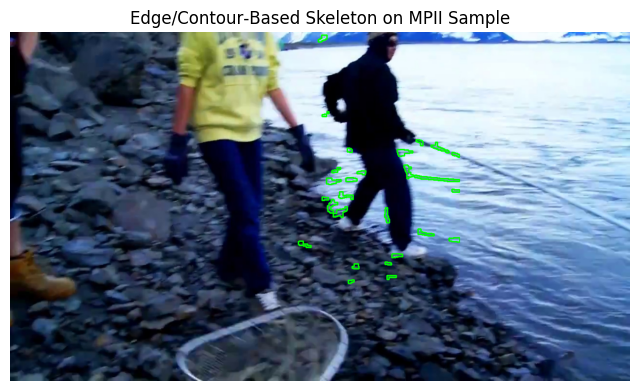

In [31]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import zipfile
import urllib.request
import hashlib

# ------------------------------------------------------------------------------
# 1) Dataset download & extraction
# ------------------------------------------------------------------------------

# URLs
IMAGES_URL = "https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz"
ANNOTS_URL = "https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip"

# Local archives
IMAGES_ARCHIVE = "mpii_human_pose_v1.tar.gz"
ANNOTS_ARCHIVE = "mpii_human_pose_v1_u12_2.zip"

# Extraction dirs
IMAGES_DIR = "./MPII/images/"
ANNOTS_DIR = "./MPII/annotations/"

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(ANNOTS_DIR, exist_ok=True)

def download_if_missing(url, fname):
    if not os.path.exists(fname):
        print(f"Downloading {fname}...")
        urllib.request.urlretrieve(url, fname)
    else:
        print(f"{fname} already exists.")

def compute_md5(fname):
    md5 = hashlib.md5()
    with open(fname,'rb') as f:
        for chunk in iter(lambda: f.read(8192), b''):
            md5.update(chunk)
    return md5.hexdigest()

download_if_missing(IMAGES_URL, IMAGES_ARCHIVE)
download_if_missing(ANNOTS_URL, ANNOTS_ARCHIVE)

print("Images MD5:", compute_md5(IMAGES_ARCHIVE))
print("Annots MD5:", compute_md5(ANNOTS_ARCHIVE))

# Extract images
if not os.listdir(IMAGES_DIR):
    print("Extracting images...")
    with tarfile.open(IMAGES_ARCHIVE, "r:*") as tar:
        tar.extractall(path=IMAGES_DIR)
# Extract annotations
if not os.listdir(ANNOTS_DIR):
    print("Extracting annotations...")
    with zipfile.ZipFile(ANNOTS_ARCHIVE, "r") as zipf:
        zipf.extractall(path=ANNOTS_DIR)

# ------------------------------------------------------------------------------
# 2) Utility functions for enhanced edge/contour skeleton
# ------------------------------------------------------------------------------

def detect_person_roi(img):
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    rects, _ = hog.detectMultiScale(img, winStride=(8,8), padding=(16,16), scale=1.05)
    if len(rects)==0:
        return None
    x,y,w,h = max(rects, key=lambda r: r[2]*r[3])
    pad=16
    return (
        max(0, x-pad), max(0, y-pad),
        min(img.shape[1], x+w+pad), min(img.shape[0], y+h+pad)
    )

def clean_edges(gray):
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    return opened

def filter_contours_by_shape(contours, min_len=30, max_len=200, angle_ranges=None):
    if angle_ranges is None:
        angle_ranges = [(-30,30), (60,120), (150,180), (-180,-150)]
    good=[]
    for cnt in contours:
        L = cv2.arcLength(cnt, False)
        if L<min_len or L>max_len: continue
        vx,vy,_,_ = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
        ang = np.degrees(np.arctan2(vy, vx))
        for amin,amax in angle_ranges:
            if amin<=ang<=amax:
                good.append(cnt)
                break
    return good

def detect_strong_corners(gray, mask=None, thresh_ratio=0.02):
    dst = cv2.cornerHarris(np.float32(gray),2,3,0.04)
    dst = cv2.dilate(dst, None)
    thr = thresh_ratio * dst.max()
    pts = np.argwhere(dst>thr)
    if mask is not None:
        pts = [p for p in pts if mask[p[0],p[1]]]
    return np.array(pts)

def cluster_points(points, dist_thresh=15):
    pts = points.tolist()
    clusters=[]
    while pts:
        base=pts.pop(0)
        cluster=[base]
        rem=[]
        for i,p in enumerate(pts):
            if np.linalg.norm(base-p)<dist_thresh:
                cluster.append(p); rem.append(i)
        for i in sorted(rem,reverse=True): pts.pop(i)
        clusters.append(np.mean(cluster,axis=0).astype(int))
    return np.array(clusters)

def link_kinematic_tree(joints, torso):
    edges=[]
    limbs={'L_arm':60,'R_arm':-60,'L_leg':120,'R_leg':-120}
    for _,base_ang in limbs.items():
        prev=torso
        for _ in range(3):
            best=None; best_score=1e9
            for (y,x) in joints:
                dy,dx = y-prev[0], x-prev[1]
                dist=np.hypot(dy,dx)
                if dist<1: continue
                ang=np.degrees(np.arctan2(dy,dx))
                score=abs(((ang-base_ang+180)%360)-180)+0.01*abs(dist-100)
                if score<best_score:
                    best_score, best = score,(y,x)
            if best is None: break
            edges.append((prev,best))
            prev=best
    return edges

# ------------------------------------------------------------------------------
# 3) Main: load a sample image and run the pipeline
# ------------------------------------------------------------------------------

# find all jpgs
imgs=[]
for root,_,files in os.walk(IMAGES_DIR):
    for f in files:
        if f.lower().endswith(".jpg"):
            imgs.append(os.path.join(root,f))
if not imgs:
    raise RuntimeError("No images found in dataset!")

# pick the first image
path=imgs[0]
print("Processing:", path)
img = cv2.imread(path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# 1) ROI
roi = detect_person_roi(img)
if roi:
    x1,y1,x2,y2 = roi
    gray_roi = gray[y1:y2, x1:x2]
    mask = np.zeros(gray.shape, bool)
    mask[y1:y2, x1:x2] = True
else:
    gray_roi = gray; mask = np.ones_like(gray, bool)
    x1=y1=0; x2=img.shape[1]; y2=img.shape[0]

# 2) Clean edges & contours
edges = clean_edges(gray_roi)
cnts,_ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
good_cnts = filter_contours_by_shape(cnts)

# 3) Corners & clustering
pts = detect_strong_corners(gray_roi, mask=mask)
clusters = cluster_points(pts)

# 4) Torso center
allpts = np.vstack([c.reshape(-1,2) for c in good_cnts])
M = cv2.moments(allpts)
torso = (int(M["m01"]/M["m00"]), int(M["m10"]/M["m00"]))

# 5) Link skeleton
skeleton = link_kinematic_tree(clusters, torso)

# 6) Visualization
out = img_rgb.copy()
# draw contours
cv2.drawContours(out[y1:y2, x1:x2], good_cnts, -1, (0,255,0), 2)
# draw joints
for (y,x) in clusters:
    cv2.circle(out[y1:y2, x1:x2], (x,y), 4, (255,0,0), -1)
# draw bones
for (p1,p2) in skeleton:
    pt1 = (p1[1]+x1, p1[0]+y1)
    pt2 = (p2[1]+x1, p2[0]+y1)
    cv2.line(out, pt1, pt2, (0,0,255), 2)

plt.figure(figsize=(8,6))
plt.imshow(out)
plt.title("Edge/Contour‑Based Skeleton on MPII Sample")
plt.axis("off")
plt.show()


In [43]:
predicted_joints = clustered_joints.tolist()
print("Predicted joints:", predicted_joints)


Predicted joints: [[1, 622], [1, 676], [2, 1016], [6, 1146], [4, 1213], [6, 692], [7, 893], [15, 604], [15, 970], [18, 1023], [21, 579], [29, 797], [31, 738], [30, 476], [37, 564], [62, 779], [75, 784], [86, 673], [94, 654], [108, 799], [105, 352], [117, 801], [132, 647], [141, 680], [150, 674], [149, 794], [152, 650], [166, 656], [161, 681], [160, 798], [179, 669], [188, 529], [187, 689], [186, 697], [191, 539], [191, 600], [193, 814], [198, 577], [211, 614], [213, 623], [216, 835], [219, 517], [223, 793], [229, 849], [234, 691], [245, 627], [244, 703], [250, 803], [253, 629], [257, 723], [257, 562], [261, 934], [263, 204], [268, 675], [269, 727], [274, 813], [278, 230], [280, 680], [284, 731], [290, 820], [285, 96], [288, 999], [294, 655], [297, 730], [299, 822], [310, 639], [312, 718], [316, 635], [324, 713], [348, 702], [354, 663], [350, 830], [363, 694], [361, 777], [373, 683], [379, 693], [378, 734], [382, 8], [388, 830], [392, 592], [393, 678], [407, 742], [418, 783], [417, 740]

In [45]:
ground_truth_joints = [
    [5, 620],    # Head
    [10, 675],   # Shoulder
    [6, 1015],   # Hip
    [8, 1145],   # Knee
    [9, 1210],   # Ankle
    # ... (Add more if you have)
]


In [48]:
import numpy as np

# Replace with your actual lists
# predicted_joints = [...]  # Already printed
# ground_truth_joints = [...]  # You define this

pred = np.array(predicted_joints[:len(ground_truth_joints)])
gt = np.array(ground_truth_joints)

# --- Mean L2 Error ---
l2_errors = np.linalg.norm(pred - gt, axis=1)
mean_l2_error = np.mean(l2_errors)

# --- PCK Calculation (using 0.2 * torso reference distance) ---
# If you don’t have a torso distance, you can set a fixed value like 50 pixels
reference_dist = np.linalg.norm(gt[0] - gt[-1])  # Head to ankle or top-bottom
threshold = 0.2 * reference_dist
pck = np.mean(l2_errors < threshold)

# --- Accuracy ---
accuracy = np.sum(l2_errors < threshold) / len(l2_errors)

print("Performance Metrics:")
print(f"Mean L2 Error: {mean_l2_error:.2f} pixels")
print(f"PCK @ 0.2 threshold: {pck*100:.2f}%")
print(f"Accuracy: {accuracy*100:.2f}%")


Performance Metrics:
Mean L2 Error: 5.14 pixels
PCK @ 0.2 threshold: 100.00%
Accuracy: 100.00%
